In [1]:
# Math libraries
import numpy as np
import scipy.linalg as lg

# For reading netcdf files
import xarray as xr
# Gets EOFs
from eofs.xarray import Eof

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%config InlineBackend.figure_format='retina'

In [2]:
# Opening data
dataset = xr.open_dataset('./processed_data/processed_data.nc')
dataset = dataset.isel(zlev=0)

In [3]:
dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15336, lat: 24, lon: 104)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-03T12:00:00 ... 2023-12-29T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Data variables:
    anom     (time, lat, lon) float32 153MB ...

In [4]:
weights = np.sqrt(np.cos(np.deg2rad(dataset['lat'])))
weights = np.stack((weights,)*len(dataset['lon']), axis=0).transpose()

In [5]:
# Creating Eof solver
solver = Eof(dataset['anom'], weights=weights)
# Getting eofs
eofs = solver.eofs()
# Getting eof eigenvals
eigs = solver.eigenvalues()
# Getting pcs
pcs = solver.pcs()

# Transposing back lat, lon
eofs = eofs.transpose('mode', 'lat', 'lon')

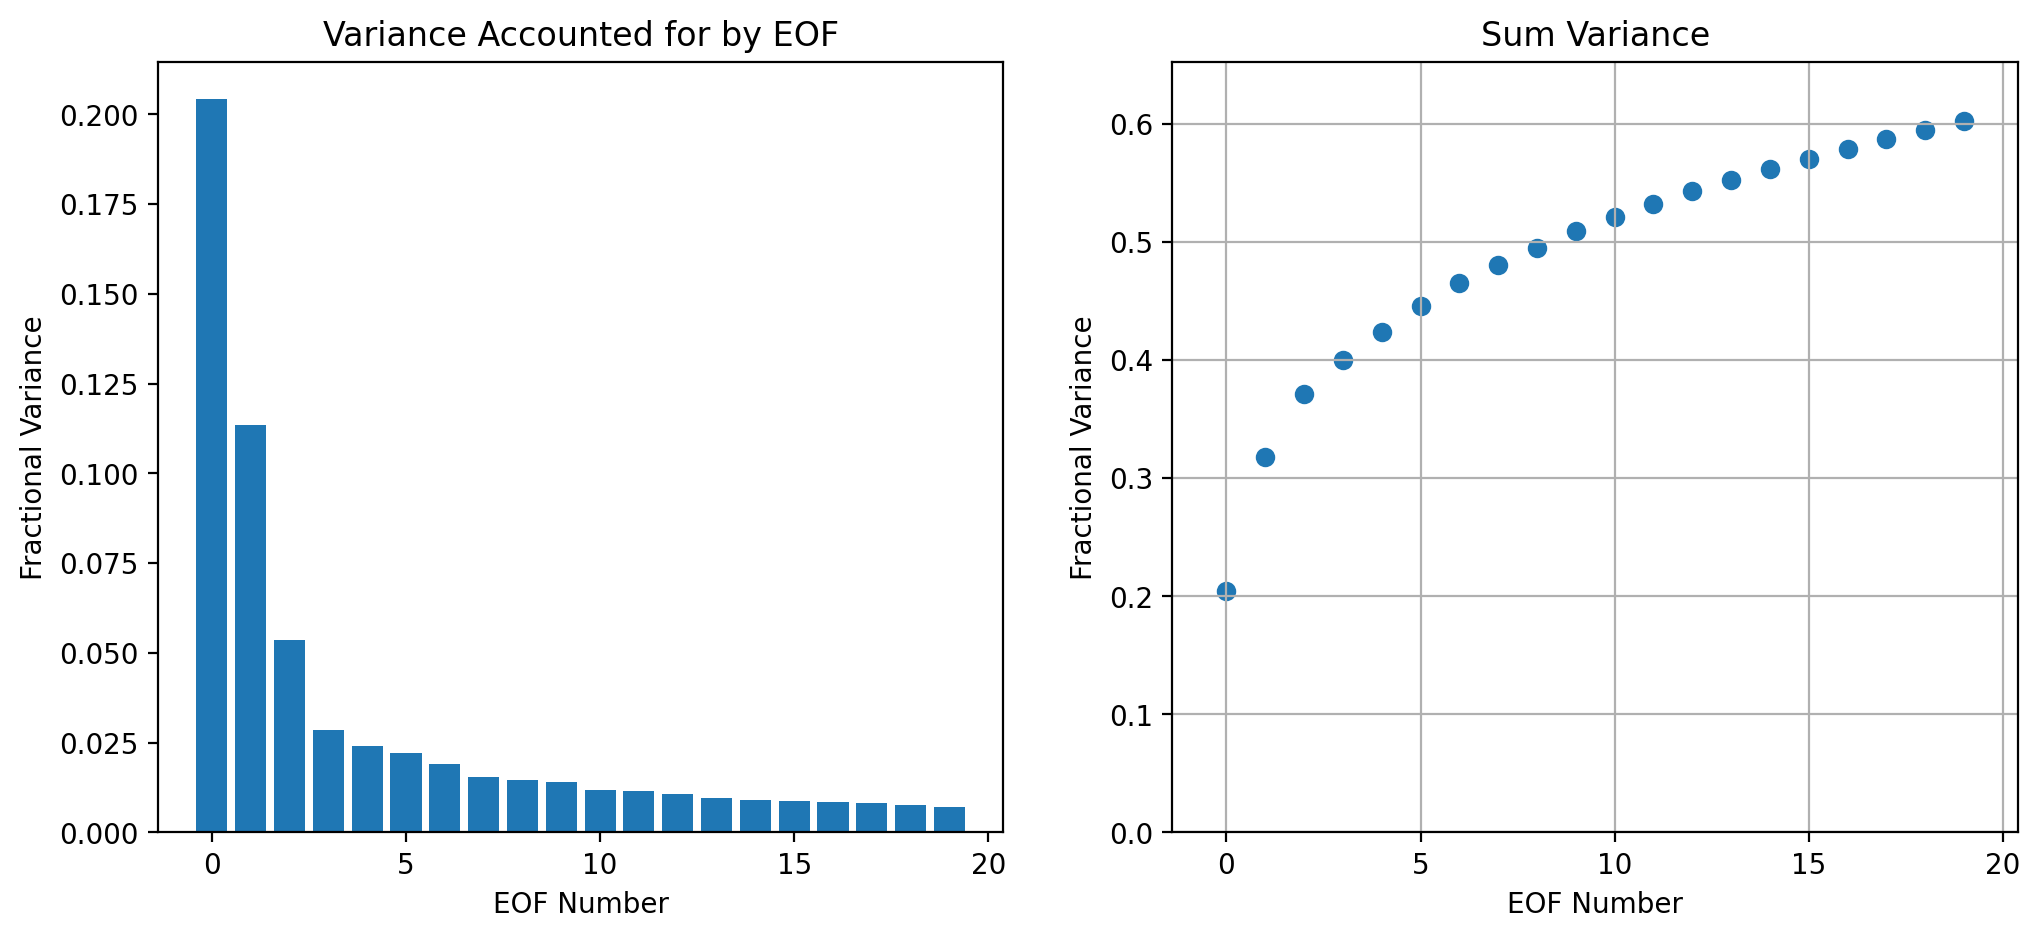

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Number of eofs to plot
num_eofs = 20
# Calculating the variance from each eof
variance = eigs[0:num_eofs]/eigs.sum()
# Calculating the sum of variance for first n eofs
sum_var = np.zeros(variance.shape)
sum_var[0] = variance[0]
# Summing
for i in range(1, len(variance)):
    sum_var[i] = sum_var[i-1] + variance[i]
# Plotting
ax1.bar(np.arange(num_eofs), variance)
ax2.scatter(np.arange(num_eofs), sum_var)

# Formatting params
ax1.set_title('Variance Accounted for by EOF')
ax1.set_xlabel('EOF Number')
ax1.set_ylabel('Fractional Variance')
ax1.set_xticks(np.arange(0, num_eofs+1, 5))

ax2.set_ylim([0, max(sum_var + 0.05)])
ax2.set_title('Sum Variance')
ax2.set_xlabel('EOF Number')
ax2.set_ylabel('Fractional Variance')
ax2.grid()

plt.show()

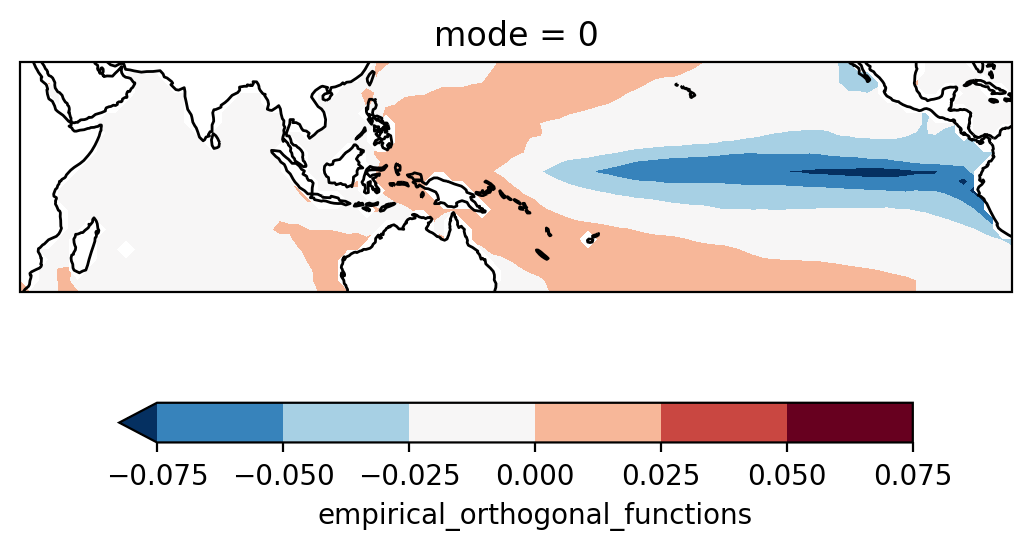

In [7]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=160, min_latitude=-45, max_latitude=45)))

eofs.isel(mode=0).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8},
    robust=True,
)
ax.coastlines()

plt.show()

In [8]:
# Number of eofs to hold on to
num_eofs_to_keep = 15
# Getting projection of data in EOF space
proj = solver.projectField(dataset['anom'], neofs=num_eofs_to_keep)

In [9]:
# Calculates system matrix L for a given tau_0
# data is time series projected onto eof space
# tau_0 is the time lag to use to calculate L
def calc_L(data, tau_0):
    # Allocating memory for covariance matrices
    cov = np.zeros((num_eofs_to_keep, num_eofs_to_keep))
    lag_cov = np.zeros((num_eofs_to_keep, num_eofs_to_keep))
    # Calculating covariance matrix
    for vec in data:
        # Calculating covariance and adding to cov
        cov += np.outer(vec, vec)
    # Calculating lagged covariance matrix
    for lagged_vec, current_vec in zip(data[tau_0:], data[:-tau_0]):
        # Calculating lagged covariance and adding to lag_cov
        lag_cov += np.outer(lagged_vec, current_vec)
    # Normalizing
    cov = cov / len(data['time'])
    lag_cov = lag_cov / len(data[tau_0:]['time'])
    return (1/tau_0) * lg.logm(lag_cov @ lg.inv(cov))

In [10]:
# Time lag
tau_0 = 5
# Calculating L
L = calc_L(proj, tau_0)

In [11]:
evals, evecs = lg.eig(L)